# RBM Wavefunction Form

This Appendix provides a derivation of the expressions introduced in the text and test codes code implementation of the RBM methodology.

We consider an RBM with
- visible spins $\sigma_i \in \{\pm 1\}$ for $i=1,\dots,N$,
- hidden spins $h_j \in \{\pm 1\}$ for $j=1,\dots,M$,
- complex parameters $\lambda=\{a_i,b_j,W_{ij}\}$.

Define the RBM "energy"

$$
E(\boldsymbol{\sigma},\boldsymbol{h}) = - \sum_{i=1}^{N} a_i \sigma_i - \sum_{j=1}^{M} b_j h_j - \sum_{i=1}^{N}\sum_{j=1}^{M} W_{ij} \sigma_i h_j
\tag{1}
$$

The (unnormalized) RBM wavefunction is the marginal over hidden spins:

$$
\psi_\lambda(\boldsymbol{\sigma}) = \sum_{\boldsymbol{h}\in\{\pm1\}^M} e^{-E(\boldsymbol{\sigma},\boldsymbol{h})}
\tag{2}
$$

Insert (1) into (2) and rearrange terms:

$$
\begin{align}
\psi_\lambda(\boldsymbol{\sigma})
&= \sum_{\boldsymbol{h}} \exp\left[
\sum_{i} a_i \sigma_i + \sum_{j} b_j h_j + \sum_{i,j} W_{ij}\sigma_i h_j
\right] \\
&= e^{\sum_i a_i \sigma_i} \sum_{\boldsymbol{h}} \exp\left[
\sum_{j} h_j \left( b_j + \sum_i W_{ij} \sigma_i \right)
\right]
\end{align}
\tag{3}
$$

Because hidden spins are conditionally independent given $\boldsymbol{\sigma}$, the sum factorizes:

$$
\psi_\lambda(\boldsymbol{\sigma}) = e^{\sum_i a_i \sigma_i} \prod_{j=1}^{M} \left[ \sum_{h_j=\pm 1} \exp( h_j x_j(\boldsymbol{\sigma}) ) \right], \quad x_j(\boldsymbol{\sigma}) \equiv b_j + \sum_{i} W_{ij}\sigma_i
\tag{4}
$$

Each inner sum is elementary:

$$
\sum_{h_j=\pm1} e^{h_j x} = e^{x} + e^{-x} = 2\cosh x
\tag{5}
$$

Applying (5) to (4) yields the closed form

$$
\boxed{
\psi_\lambda(\boldsymbol{\sigma}) = \exp\left(\sum_{i=1}^{N} a_i \sigma_i\right) \prod_{j=1}^{M} 2\cosh\left( b_j + \sum_{i=1}^{N} W_{ij}\sigma_i \right)
}
\tag{6}
$$

**Remarks:**
- Allowing $a_i,b_j,W_{ij}\in\mathbb{C}$ encodes both amplitude and phase of the quantum state in (6).
- If binary variables $v_i,h_j\in\{0,1\}$ are preferred, write the energy $E(v,h)=-\sum_i \tilde a_i v_i-\sum_j \tilde b_j h_j-\sum_{ij}\tilde W_{ij} v_i h_j$ and repeat the steps; using $\sum_{h_j\in\{0,1\}} e^{h_j x} = 1+e^{x} = e^{x/2} 2\cosh(x/2)$ gives an equivalent form up to an overall (state-independent) factor.
- A normalized state is $|\Psi\rangle = \sum_{\boldsymbol{\sigma}}\psi_\lambda(\boldsymbol{\sigma}) | \boldsymbol{\sigma}\rangle / \mathcal{N}$ with $\mathcal{N}=\sqrt{\sum_{\boldsymbol{\sigma}}|\psi_\lambda(\boldsymbol{\sigma})|^2}$.



In [3]:
import numpy as np
import matplotlib.pyplot as plt

class RestrictedBoltzmannMachine:
    """
    RBM with binary spins σ_i ∈ {-1, +1} for visible layer
    and h_j ∈ {-1, +1} for hidden layer.
    
    COMPLEX PARAMETERS: a_i, b_j, W_ij ∈ ℂ
    
    The RBM wavefunction is:
    ψ_λ(σ) = exp(Σ_i a_i σ_i) × ∏_j 2cosh(θ_j)
    
    where θ_j = b_j + Σ_i W_ij σ_i
    
    The probability distribution for sampling is:
    P(σ) = |ψ_λ(σ)|² / Z
    """
    
    def __init__(self, n_visible, n_hidden, seed=42):
        """
        Initialize RBM with random complex parameters.
        
        Parameters:
        -----------
        n_visible : int
            Number of visible units (spins)
        n_hidden : int
            Number of hidden units
        seed : int, optional
            Random seed for reproducibility
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.rng = np.random.default_rng(seed)
        
        # Initialize COMPLEX parameters
        # Each parameter has real and imaginary parts
        scale = 0.01
        
        # Visible biases: a_i ∈ ℂ
        self.a = scale * (self.rng.standard_normal(n_visible) + 
                         1j * self.rng.standard_normal(n_visible))
        
        # Hidden biases: b_j ∈ ℂ
        self.b = scale * (self.rng.standard_normal(n_hidden) + 
                         1j * self.rng.standard_normal(n_hidden))
        
        # Weights: W_ij ∈ ℂ
        self.W = scale * (self.rng.standard_normal((n_visible, n_hidden)) + 
                         1j * self.rng.standard_normal((n_visible, n_hidden)))
        
        print(f"Created Complex RBM with {n_visible} visible and {n_hidden} hidden units")
        print(f"Total parameters: {self.count_parameters()}")
        print(f"  (Each parameter has real and imaginary parts)")
    
    def count_parameters(self):
        """Count total number of trainable parameters."""
        # Each complex parameter counts as 2 real parameters
        return 2 * (self.n_visible + self.n_hidden + self.n_visible * self.n_hidden)
    
    def energy(self, sigma, h): # we don't really need this part: just for pedagogical purposes )
        """
        Compute the energy E(σ, h) for a configuration.
        
        E(σ, h) = -Σ_i a_i σ_i - Σ_j b_j h_j - Σ_ij W_ij σ_i h_j
        
        Note: Even with complex parameters, the energy in the exponential
        is used to define the probability, so we work with the wavefunction directly.
        """
        visible_term = -np.dot(self.a, sigma)
        hidden_term = -np.dot(self.b, h)
        interaction_term = -np.dot(sigma, np.dot(self.W, h))
        
        return visible_term + hidden_term + interaction_term
    
    def log_wavefunction(self, sigma):
        """
        Compute log ψ_λ(σ) for numerical stability.
        
        log ψ_λ(σ) = Σ_i a_i σ_i + Σ_j log(2cosh(θ_j))
        
        where θ_j = b_j + Σ_i W_ij σ_i
        
        Returns complex number.
        """
        # Visible layer contribution
        visible_term = np.dot(self.a, sigma)
        
        # Hidden layer contribution (after marginalizing)
        theta = self.b + np.dot(sigma, self.W)
        hidden_term = np.sum(np.log(2.0 * np.cosh(theta)))
        
        return visible_term + hidden_term
    
    def wavefunction(self, sigma):
        """
        Compute the complex wavefunction ψ_λ(σ).
        
        ψ_λ(σ) = exp(Σ_i a_i σ_i) × ∏_j 2cosh(θ_j)
        
        Returns: complex number
        """
        return np.exp(self.log_wavefunction(sigma))
    
    def probability_unnormalized(self, sigma):
        """
        Compute unnormalized probability P(σ) ∝ |ψ_λ(σ)|².
        
        This is what we sample from!
        
        Returns: real number (probability)
        """
        psi = self.wavefunction(sigma)
        return np.abs(psi)**2  # |ψ|² = ψ* × ψ
    
    def log_probability_unnormalized(self, sigma):
        """
        Compute log|ψ_λ(σ)|² = 2 Re[log ψ_λ(σ)] for numerical stability.
        
        This is useful for Metropolis-Hastings to avoid overflow.
        """
        log_psi = self.log_wavefunction(sigma)
        return 2 * np.real(log_psi)

# Demonstrate the Complex RBM
print("="*60)
print("SECTION 1: Complex RBM as a Probability Distribution")
print("="*60)

# Create a small complex RBM
rbm = RestrictedBoltzmannMachine(n_visible=3, n_hidden=4, seed=42)

print("\nComplex RBM Parameters:")
print(f"Visible biases a (complex):")
for i, a_i in enumerate(rbm.a):
    print(f"  a_{i} = {a_i.real:.6f} + {a_i.imag:.6f}i")

print(f"\nHidden biases b (complex):")
for j, b_j in enumerate(rbm.b):
    print(f"  b_{j} = {b_j.real:.6f} + {b_j.imag:.6f}i")

print(f"\nWeights W (complex) shape: {rbm.W.shape}")
print(f"  Example: W_{{0,0}} = {rbm.W[0,0].real:.6f} + {rbm.W[0,0].imag:.6f}i")

# Example configuration
sigma_example = np.array([1, -1, 1])

print(f"\nExample visible configuration σ: {sigma_example}")

# Compute wavefunction and probability
psi = rbm.wavefunction(sigma_example)
prob_unnorm = rbm.probability_unnormalized(sigma_example)

print(f"\nWavefunction ψ_λ(σ):")
print(f"  Real part: {psi.real:.6f}")
print(f"  Imaginary part: {psi.imag:.6f}")
print(f"  Magnitude |ψ|: {np.abs(psi):.6f}")
print(f"  Phase arg(ψ): {np.angle(psi):.6f} radians")

print(f"\nUnnormalized probability |ψ_λ(σ)|²: {prob_unnorm:.6f}")

# Verify relationship
print(f"\nVerifying |ψ|² = ψ* × ψ:")
psi_conj = np.conj(psi)
prob_check = np.real(psi_conj * psi)
print(f"  ψ* × ψ = {prob_check:.6f}")
print(f"  |ψ|² = {prob_unnorm:.6f}")
print(f"  Match? {np.isclose(prob_check, prob_unnorm)}")

# Compare several configurations
print("\n" + "-"*60)
print("Comparing different configurations:")
print("-"*60)

test_configs = [
    np.array([1, 1, 1]),
    np.array([1, -1, 1]),
    np.array([-1, -1, -1]),
    np.array([1, 1, -1]),
]

for i, sigma in enumerate(test_configs):
    psi = rbm.wavefunction(sigma)
    prob = rbm.probability_unnormalized(sigma)
    print(f"\nConfig {i+1}: {sigma}")
    print(f"  ψ = {psi.real:.4f} + {psi.imag:.4f}i")
    print(f"  |ψ|² = {prob:.6f}")

print(" The (complex) RBM encodes both amplitude and phase information")
print("  This is essential for representing general quantum states.")

SECTION 1: Complex RBM as a Probability Distribution
Created Complex RBM with 3 visible and 4 hidden units
Total parameters: 38
  (Each parameter has real and imaginary parts)

Complex RBM Parameters:
Visible biases a (complex):
  a_0 = 0.003047 + 0.009406i
  a_1 = -0.010400 + -0.019510i
  a_2 = 0.007505 + -0.013022i

Hidden biases b (complex):
  b_0 = 0.001278 + 0.008794i
  b_1 = -0.003162 + 0.007778i
  b_2 = -0.000168 + 0.000660i
  b_3 = -0.008530 + 0.011272i

Weights W (complex) shape: (3, 4)
  Example: W_{0,0} = 0.004675 + 0.005323i

Example visible configuration σ: [ 1 -1  1]

Wavefunction ψ_λ(σ):
  Real part: 16.332294
  Imaginary part: 0.250277
  Magnitude |ψ|: 16.334211
  Phase arg(ψ): 0.015323 radians

Unnormalized probability |ψ_λ(σ)|²: 266.806453

Verifying |ψ|² = ψ* × ψ:
  ψ* × ψ = 266.806453
  |ψ|² = 266.806453
  Match? True

------------------------------------------------------------
Comparing different configurations:
----------------------------------------------------

## Sampling from an RBM Quantum State

We wish to draw samples $\boldsymbol{\sigma}$ from the probability distribution

$$
p(\boldsymbol{\sigma}) = \frac{|\psi_\lambda(\boldsymbol{\sigma})|^2}{\mathcal{Z}}
$$

where the RBM wavefunction is

$$
\psi_\lambda(\boldsymbol{\sigma}) = \exp\left(\sum_i a_i \sigma_i\right) \prod_{j=1}^M 2\cosh(\theta_j), \qquad \theta_j = b_j + \sum_i W_{ij}\sigma_i
$$

In general the parameters $\{a_i,b_j,W_{ij}\}$ are complex, so we cannot sample exactly using classical Gibbs updates. Instead, we employ the **Metropolis-Hastings** algorithm on the visible spins.

### Metropolis-Hastings updates

**Proposal:** At each step, choose a visible spin index $i$ at random and propose to flip it:

$$
\sigma_i' = -\sigma_i, \qquad \boldsymbol{\sigma}' = (\sigma_1,\ldots,\sigma_i',\ldots,\sigma_N)
$$

Efficiently update the hidden pre-activations

$$
\theta_j' = \theta_j - 2 W_{ij}\sigma_i, \quad \forall j
$$

**Acceptance ratio:** The acceptance probability for this move is

$$
A(\boldsymbol{\sigma}\to\boldsymbol{\sigma}') = \min(1, R), \qquad R = \frac{|\psi_\lambda(\boldsymbol{\sigma}')|^2}{|\psi_\lambda(\boldsymbol{\sigma})|^2}
$$

Explicitly,

$$
R = \exp(-4\mathrm{Re}[a_i\sigma_i]) \prod_{j=1}^M \frac{|\cosh(\theta_j - 2 W_{ij}\sigma_i)|^2}{|\cosh(\theta_j)|^2}
$$

Accept the flip with probability $A$, otherwise keep $\boldsymbol{\sigma}$.

**Implementation details:**
- The computational cost per proposed flip is $\mathcal{O}(M)$ if the vector $\{\theta_j\}$ is maintained.
- Use multiple independent Markov chains, a burn-in period, and thin the samples according to the integrated autocorrelation time.
- Multi-spin or cluster proposals can improve mixing.

### Block Gibbs sampling (real parameters only)

If all parameters are real, so that $|\psi_\lambda(\boldsymbol{\sigma})|^2$ is a genuine classical RBM probability distribution, one can perform block Gibbs sampling by alternating between visible and hidden layers:

$$
P(h_j = 1 \mid \boldsymbol{\sigma}) = \sigma\left(b_j + \sum_i W_{ij}\sigma_i\right)
$$

$$
P(\sigma_i = 1 \mid \boldsymbol{h}) = \sigma\left(a_i + \sum_j W_{ij} h_j\right)
$$

where $\sigma(x)=1/(1+e^{-x})$ is the logistic function (for $\{0,1\}$ encoding of spins). For complex parameters this method is invalid, so Metropolis-Hastings is preferred.


SECTION 2: Sampling from Complex RBM Distribution

Key difference from real RBM:
  We sample from P(σ) = |ψ_λ(σ)|² / Z

  Even though ψ_λ is complex, the probability |ψ_λ|² is always real and positive.

  Metropolis-Hastings acceptance ratio:
    R = |ψ_λ(σ')|² / |ψ_λ(σ)|²
      = exp[2 Re(log ψ_λ(σ')) - 2 Re(log ψ_λ(σ))]

Created Complex RBM with 4 visible and 6 hidden units
Total parameters: 68
  (Each parameter has real and imaginary parts)

Demonstrating that probability is real even with complex ψ:
Configuration: [ 1 -1  1 -1]
ψ(σ) = 64.338897 + -0.492062i (complex)
|ψ(σ)|² = 4139.735799 (real and positive)

Starting MCMC sampling from |ψ_λ|²...
  Burn-in: 1000 steps
  Collecting: 5000 samples
  Thinning: every 5 steps
  Total MCMC steps: 26000
  Step 2000/26000, acceptance rate: 0.980
  Step 4000/26000, acceptance rate: 0.984
  Step 6000/26000, acceptance rate: 0.986
  Step 8000/26000, acceptance rate: 0.986
  Step 10000/26000, acceptance rate: 0.986
  Step 12000/26000, acceptan

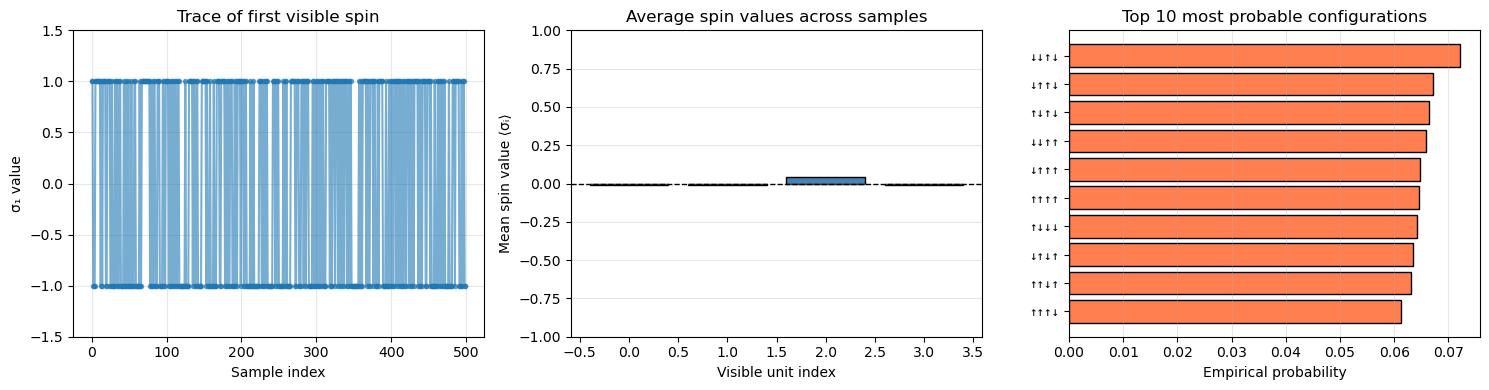

In [4]:
print("\n" + "="*60)
print("SECTION 2: Sampling from Complex RBM Distribution")
print("="*60)

print("""
Key difference from real RBM:
  We sample from P(σ) = |ψ_λ(σ)|² / Z
  
  Even though ψ_λ is complex, the probability |ψ_λ|² is always real and positive.
  
  Metropolis-Hastings acceptance ratio:
    R = |ψ_λ(σ')|² / |ψ_λ(σ)|²
      = exp[2 Re(log ψ_λ(σ')) - 2 Re(log ψ_λ(σ))]
""")

class RBMSampler(RestrictedBoltzmannMachine):
    """Extends Complex RBM with sampling methods."""
    
    def metropolis_hastings_step(self, sigma):
        """
        One step of Metropolis-Hastings: propose flipping one random spin.
        
        For complex RBM:
        Acceptance ratio: R = |ψ(σ')|² / |ψ(σ)|²
        
        Using log probabilities for numerical stability:
        log R = 2[Re(log ψ(σ')) - Re(log ψ(σ))]
        """
        # Current log probability
        log_prob_old = self.log_probability_unnormalized(sigma)
        
        # Propose flipping a random spin
        i = self.rng.integers(self.n_visible)
        sigma_prime = sigma.copy()
        sigma_prime[i] *= -1
        
        # New log probability
        log_prob_new = self.log_probability_unnormalized(sigma_prime)
        
        # Log acceptance ratio --- at this step Z would cancel so we don't even need it!
        log_R = log_prob_new - log_prob_old
        
        # Acceptance probability A = min(1, R)
        A = min(1.0, np.exp(log_R))
        
        # Accept with probability A
        if self.rng.random() < A:
            return sigma_prime, True  # accepted
        else:
            return sigma, False  # rejected
    
    def metropolis_hastings_step_fast(self, sigma, log_prob_old, theta_old):
        """
        Optimized version that reuses computed quantities.
        
        Parameters:
        -----------
        sigma : array
            Current configuration
        log_prob_old : float
            Pre-computed log|ψ(σ)|²
        theta_old : array (complex)
            Pre-computed θ_j = b_j + Σ_i W_ij σ_i
            
        Returns:
        --------
        sigma_new, accepted, log_prob_new, theta_new
        """
        # Propose flipping a random spin
        i = self.rng.integers(self.n_visible)
        sigma_prime = sigma.copy()
        sigma_prime[i] *= -1
        
        # Update theta efficiently: θ'_j = θ_j - 2 W_ij σ_i
        theta_new = theta_old - 2.0 * self.W[i, :] * sigma[i]
        
        # Compute new log probability
        visible_term = np.dot(self.a, sigma_prime)
        hidden_term = np.sum(np.log(2.0 * np.cosh(theta_new)))
        log_psi_new = visible_term + hidden_term
        log_prob_new = 2 * np.real(log_psi_new)
        
        # Log acceptance ratio
        log_R = log_prob_new - log_prob_old
        
        # Acceptance probability A = min(1, R)
        A = min(1.0, np.exp(log_R))
        
        # Accept with probability A
        if self.rng.random() < A:
            return sigma_prime, True, log_prob_new, theta_new  # accepted
        else:
            return sigma, False, log_prob_old, theta_old  # rejected
    
    
    def sample_from_distribution(self, n_samples, burn_in=1000, thin=10, 
                                 verbose=True, use_fast=True):
        """
        Generate samples from P(σ) = |ψ_λ(σ)|² using Metropolis-Hastings.
        
        Parameters:
        -----------
        n_samples : int
            Number of samples to collect
        burn_in : int
            Number of initial steps to discard
        thin : int
            Keep only every thin-th sample
        use_fast : bool
            Use optimized version with theta caching
        """
        if verbose:
            print(f"\nStarting MCMC sampling from |ψ_λ|²...")
            print(f"  Burn-in: {burn_in} steps")
            print(f"  Collecting: {n_samples} samples")
            print(f"  Thinning: every {thin} steps")
            print(f"  Total MCMC steps: {burn_in + n_samples * thin}")
        
        # Start from random configuration
        sigma = 2 * self.rng.integers(0, 2, size=self.n_visible) - 1
        
        if use_fast:
            # Pre-compute for fast updates
            log_prob = self.log_probability_unnormalized(sigma)
            theta = self.b + np.dot(sigma, self.W)
        
        samples = []
        n_accepted = 0
        total_steps = burn_in + n_samples * thin
        
        for step in range(total_steps):
            if use_fast:
                sigma, accepted, log_prob, theta = self.metropolis_hastings_step_fast(
                    sigma, log_prob, theta
                )
            else:
                sigma, accepted = self.metropolis_hastings_step(sigma)
            
            if accepted:
                n_accepted += 1
            
            # After burn-in, collect samples with thinning
            if step >= burn_in and (step - burn_in) % thin == 0:
                samples.append(sigma.copy())
            
            # Progress indicator
            if verbose and (step + 1) % 2000 == 0:
                acceptance_rate = n_accepted / (step + 1)
                print(f"  Step {step + 1}/{total_steps}, acceptance rate: {acceptance_rate:.3f}")
        
        acceptance_rate = n_accepted / total_steps
        if verbose:
            print(f"\n✓ Sampling complete!")
            print(f"  Final acceptance rate: {acceptance_rate:.3f}")
            print(f"  (Optimal range: 0.2 - 0.5 for Metropolis-Hastings)")
        
        return np.array(samples)

# Create sampler
sampler = RBMSampler(n_visible=4, n_hidden=6, seed=123)

print("\nDemonstrating that probability is real even with complex ψ:")
test_sigma = np.array([1, -1, 1, -1])
psi = sampler.wavefunction(test_sigma)
prob = sampler.probability_unnormalized(test_sigma)

print(f"Configuration: {test_sigma}")
print(f"ψ(σ) = {psi.real:.6f} + {psi.imag:.6f}i (complex)")
print(f"|ψ(σ)|² = {prob:.6f} (real and positive)")

# Generate samples
samples = sampler.sample_from_distribution(n_samples=5000, burn_in=1000, thin=5)

print(f"\nCollected {len(samples)} samples")
print(f"Sample shape: {samples.shape}")
print(f"\nFirst 10 samples:")
for i, s in enumerate(samples[:10]):
    psi_s = sampler.wavefunction(s)
    prob_s = sampler.probability_unnormalized(s)
    print(f"  Sample {i+1}: {s} → |ψ|² = {prob_s:.6f}")

# Analyze the distribution
unique, counts = np.unique(samples, axis=0, return_counts=True)
empirical_probs = counts / len(samples)

print(f"\nEmpirical distribution (top 5 most common configurations):")
sorted_idx = np.argsort(-counts)
for i in sorted_idx[:5]:
    config = unique[i]
    prob_emp = empirical_probs[i]
    psi_config = sampler.wavefunction(config)
    print(f"  {config}: p={prob_emp:.4f}, ψ={psi_config.real:.3f}+{psi_config.imag:.3f}i")

# Visualize samples
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Sample trace
axes[0].plot(samples[:500, 0], 'o-', markersize=3, alpha=0.6)
axes[0].set_xlabel('Sample index')
axes[0].set_ylabel('σ₁ value')
axes[0].set_title('Trace of first visible spin')
axes[0].set_ylim([-1.5, 1.5])
axes[0].grid(True, alpha=0.3)

# Plot 2: Spin averages
spin_means = samples.mean(axis=0)
axes[1].bar(range(sampler.n_visible), spin_means, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Visible unit index')
axes[1].set_ylabel('Mean spin value ⟨σᵢ⟩')
axes[1].set_title('Average spin values across samples')
axes[1].set_ylim([-1, 1])
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Configuration probabilities
top_n = 10
top_configs = unique[sorted_idx[:top_n]]
top_probs = empirical_probs[sorted_idx[:top_n]]
config_labels = [''.join(['↑' if s==1 else '↓' for s in cfg]) for cfg in top_configs]

axes[2].barh(range(top_n), top_probs, color='coral', edgecolor='black')
axes[2].set_yticks(range(top_n))
axes[2].set_yticklabels(config_labels, fontfamily='monospace', fontsize=9)
axes[2].set_xlabel('Empirical probability')
axes[2].set_title(f'Top {top_n} most probable configurations')
axes[2].invert_yaxis()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('complex_rbm_samples.png', dpi=100, bbox_inches='tight')
print("\n✓ Saved visualization to 'complex_rbm_samples.png'")

print("""
\nKey insight:
  • The wavefunction ψ_λ(σ) is COMPLEX (has phase)
  • The probability |ψ_λ(σ)|² is REAL (can be sampled)
  • Complex parameters enable representation of quantum interference and entanglement
""")

In [5]:
import netket as nk
import netket.experimental as nkx

In [6]:
# this can be done more efficiently using NetKet:

# code to make the RBM -- here alpha is the ratio between the number of hidden and visible spins
rbm = nk.models.RBM(alpha=1)
print(rbm)

RBM(
    # attributes
    param_dtype = float64
    activation = log_cosh
    alpha = 1
    use_hidden_bias = True
    use_visible_bias = True
    precision = None
    kernel_init = init
    hidden_bias_init = init
    visible_bias_init = init
)


In [7]:
# define hilbert space we're working with - N-qubit hamiltonian
# cf: obtained from a second-quantized fermionic hamiltonian in the atomic STO-3G basis ... 

hi = nk.hilbert.Qubit(N=4)

In [8]:
# code to create the sampler - use the hilbert space defined above and specifiy the number of markov chains for MCMC
sa = nk.sampler.MetropolisLocal(hilbert=hi,n_chains=16)

In [9]:
# define optimizer to optimize the parameters
optimizer = nk.optimizer.Sgd(learning_rate=5e-2)

In [10]:
# define the variational state - specifiy the sampler and the model to sample from
vs = nk.vqs.MCState(
    sampler=sa,
    model=rbm,
    n_samples=1000,
)

/Users/briangitahi/miniconda3/envs/nqs_env/lib/python3.11/site-packages/netket/vqs/mc/mc_state/state.py:299: UserWarning: n_samples=1000 (1000 per JAX device) does not divide n_chains=16, increased to 1008 (1008 per JAX device)
  self.n_samples = n_samples


In [11]:
# get the training data made by separate script

from typing import Tuple, List

def load_and_prepare_for_training(filename: str, spin_notation: bool = False) -> Tuple[list, list]:
    """
    Load measurement dataset and convert to training format (sigma_s, Us).
    
    Args:
        filename: Path to dataset file (e.g., "measurements.txt")
        spin_notation: If True, outcomes are {-1,+1}. If False, {0,1}
    
    Returns:
        (sigma_s, Us) where:
            sigma_s: List of measurement outcomes as numpy arrays
            Us: List of measurement bases (e.g., ['X', 'Z', 'Y'])
    
    Example:
        >>> sigma_s, Us = load_and_prepare_for_training("data.txt")
        >>> print(sigma_s[0])  # First outcome: [0, 1, 0, 1]
        >>> print(Us[0])       # First bases: ['X', 'Z', 'Z', 'Y']
    """
    sigma_s = []
    Us = []
    
    with open(filename, 'r') as f:
        for line in f:
            bases_str, outcome_str = line.strip().split()
            
            # Convert outcome string to array: "0101" -> [0, 1, 0, 1]
            outcome = np.array([int(bit) for bit in outcome_str])
            
            # Convert to spin notation if requested: 0->+1, 1->-1
            if spin_notation:
                outcome = 1 - 2 * outcome
            
            # Convert bases string to list: "XZZY" -> ['X', 'Z', 'Z', 'Y']
            #bases = list(bases_str) - netket complained about this
            
            sigma_s.append(outcome)
            Us.append(bases_str)
    
    print(f"Loaded {len(sigma_s)} measurements from {filename}")
    print(f"Format: {'spin {-1,+1}' if spin_notation else 'binary {0,1}'}")
    
    return np.array(sigma_s), Us

In [12]:
# Load dataset for training
sigma_s, Us = load_and_prepare_for_training("../Scripts/4qubit_measurements.txt", spin_notation=True)

Loaded 5000 measurements from ../Scripts/4qubit_measurements.txt
Format: spin {-1,+1}


In [13]:
type(Us)

list

In [14]:
Us[0]

'YYYY'

In [12]:
type(sigma_s)

numpy.ndarray

In [13]:
np.shape(sigma_s)

(5000, 4)

In [14]:
type(sigma_s)

numpy.ndarray

In [15]:
# cf what a driver is
# define the driver for the training -- try 64 batch size later
driver = nkx.QSR(training_data = (sigma_s,Us) , training_batch_size=32 , optimizer = optimizer, variational_state=vs)

In [16]:
# object to log the details of training -- check specs
logger = nk.logging.RuntimeLog()

In [17]:
# run the driver
driver.run(n_iter=100, out=logger,  obs={'NLL': driver._loss_stats})


  0%|          | 0/100 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance'],)

In [18]:
print(driver._loss_stats)

None


In [19]:
driver.nll(return_stats=True)

-70.58 ± 0.73 [σ²=2.8e+03]

In [22]:
loss_steps = driver._loss_stats

In [23]:
print(loss_steps)

None


In [24]:
print(logger)

RuntimeLog():
 keys = ['acceptance']


In [25]:
loss = driver.nll_whole_training_set(return_stats=True)
print(loss)

-70.58 ± 0.73 [σ²=2.8e+03]


In [26]:
driver._log_additional_data

<bound method AbstractVariationalDriver._log_additional_data of QSR(
  step_count = 100,
  state = MCState(hilbert = Qubit(N=4), sampler = MetropolisSampler(rule = LocalRule(), n_chains = 16, sweep_size = 4, reset_chains = False, machine_power = 2, dtype = int8), n_samples = 1008))>

In [27]:
acceptance = logger["acceptance"]

Text(0.5, 1.0, 'Acceptrance rate of the proposed configuration')

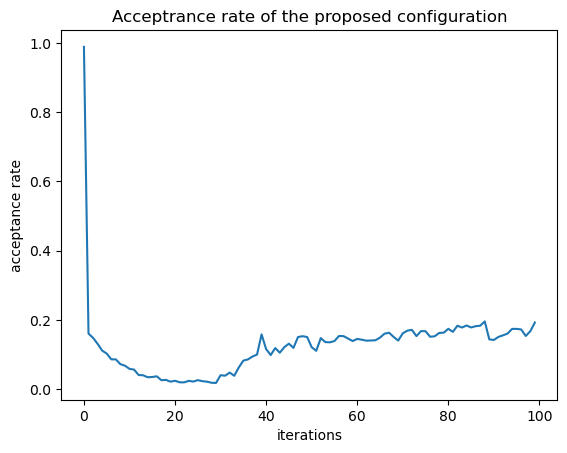

In [28]:
plt.plot(range(len(acceptance)), acceptance)
plt.xlabel("iterations")
plt.ylabel("acceptance rate")
plt.title("Acceptrance rate of the proposed configuration")

In [29]:
# find way to output the loss

# find way to access the access the state itself

# reproduce measurement outcomees?

# measure an observable or just some pauli words?


In [30]:
# BONUS: When doing the example of the BeH2 molecule, calculate expcilictly the ground state
# and get plot the fidelity of the reconstructed state of the rbm at each training iteration 
# like in Juan's tutorial! should see sigmoid like shape like Alex's plot too


### Using the samples

Once $n_{\mathrm{MC}}$ samples $\{\boldsymbol{\sigma}^{(k)}\}_{k=1}^{n_{\mathrm{MC}}} \sim |\psi_\lambda|^2$ are collected, any observable can be estimated using the *local estimator*:

$$
O_\lambda = \frac{1}{n_{\mathrm{MC}}} \sum_{k=1}^{n_{\mathrm{MC}}} \frac{\langle \boldsymbol{\sigma}^{(k)}| \hat{O} |\psi_\lambda\rangle}{\langle \boldsymbol{\sigma}^{(k)}|\psi_\lambda\rangle}
$$

This estimator converges to $\langle \hat{O} \rangle$ in the limit of large $n_{\mathrm{MC}}$.

## Training an RBM to Reproduce Quantum Measurement Distributions

Assume a quantum circuit prepares an $N$-qubit state $|\psi\rangle$. Repeated measurements in some local basis (e.g. the computational $Z$ basis) produce a dataset of binary outcomes

$$
\mathcal{D} = \{\boldsymbol{\sigma}^{(1)}, \boldsymbol{\sigma}^{(2)}, \ldots, \boldsymbol{\sigma}^{(M)}\}, \qquad \boldsymbol{\sigma}^{(k)} \in \{\pm 1\}^N
$$

Each bitstring $\boldsymbol{\sigma}$ is observed with probability

$$
P_{\mathrm{data}}(\boldsymbol{\sigma}) = |\langle \boldsymbol{\sigma} | \psi \rangle|^2
$$

Our goal is to train a Restricted Boltzmann Machine (RBM) such that its marginal probability distribution $P_\lambda(\boldsymbol{\sigma})$ approximates $P_{\mathrm{data}}(\boldsymbol{\sigma})$.

### RBM model of the measurement distribution

The RBM defines a joint distribution over visible and hidden spins $\boldsymbol{\sigma}$ and $\boldsymbol{h}$:

$$
P_\lambda(\boldsymbol{\sigma}, \boldsymbol{h}) = \frac{1}{Z_\lambda} \exp\left( \sum_i a_i \sigma_i + \sum_j b_j h_j + \sum_{ij} W_{ij}\sigma_i h_j \right)
$$

with partition function

$$
Z_\lambda = \sum_{\boldsymbol{\sigma},\boldsymbol{h}} \exp[-E_\lambda(\boldsymbol{\sigma},\boldsymbol{h})]
$$

The visible-layer marginal is then

$$
P_\lambda(\boldsymbol{\sigma}) = \sum_{\boldsymbol{h}} P_\lambda(\boldsymbol{\sigma},\boldsymbol{h}) = \frac{1}{Z_\lambda} e^{\sum_i a_i \sigma_i} \prod_j 2\cosh\left(b_j + \sum_i W_{ij}\sigma_i\right)
$$

### Training objective

We minimize the Kullback-Leibler (KL) divergence between the true data distribution and the RBM model:

$$
\mathcal{C}(\lambda) = D_{\mathrm{KL}}(P_{\mathrm{data}} \| P_\lambda) = \sum_{\boldsymbol{\sigma}} P_{\mathrm{data}}(\boldsymbol{\sigma}) \ln \frac{P_{\mathrm{data}}(\boldsymbol{\sigma})}{P_\lambda(\boldsymbol{\sigma})}
$$

Because the term involving $P_{\mathrm{data}}$ is constant w.r.t. $\lambda$, minimizing $\mathcal{C}$ is equivalent to maximizing the log-likelihood of the data:

$$
\mathcal{L}(\lambda) = \sum_{\boldsymbol{\sigma}\in\mathcal{D}} \ln P_\lambda(\boldsymbol{\sigma}) = \sum_{\boldsymbol{\sigma}\in\mathcal{D}} \left[ \sum_i a_i \sigma_i + \sum_j \ln 2\cosh\left(b_j + \sum_i W_{ij}\sigma_i\right) \right] - M \ln Z_\lambda
$$

### Gradient of the log-likelihood

The derivatives of $\mathcal{L}$ with respect to the parameters are

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial a_i} &= \langle \sigma_i \rangle_{\mathrm{data}} - \langle \sigma_i \rangle_{\mathrm{model}} \\[4pt]
\frac{\partial \mathcal{L}}{\partial b_j} &= \langle \tanh(\theta_j) \rangle_{\mathrm{data}} - \langle \tanh(\theta_j) \rangle_{\mathrm{model}} \\[4pt]
\frac{\partial \mathcal{L}}{\partial W_{ij}} &= \langle \sigma_i \tanh(\theta_j) \rangle_{\mathrm{data}} - \langle \sigma_i \tanh(\theta_j) \rangle_{\mathrm{model}}
\end{align}
$$

where

$$
\theta_j = b_j + \sum_i W_{ij}\sigma_i
$$

Here $\langle \cdot \rangle_{\mathrm{data}}$ denotes averages over the training dataset $\mathcal{D}$, and $\langle \cdot \rangle_{\mathrm{model}}$ denotes averages over samples drawn from the current RBM distribution $P_\lambda(\boldsymbol{\sigma})$.

### Learning algorithm

The gradients are estimated by Monte Carlo sampling, and the parameters are updated iteratively by stochastic gradient ascent:

$$
\lambda \leftarrow \lambda + \eta \nabla_\lambda \mathcal{L}
$$

where $\eta$ is the learning rate.

In practice, the expectation $\langle \cdot \rangle_{\mathrm{model}}$ is approximated by short Markov chains (initialized at data samples) using the *Contrastive Divergence* (CD-$k$) algorithm.

### Interpretation

During training, the RBM learns to approximate the probability distribution of measurement outcomes produced by the quantum circuit. If training converges ideally, we obtain

$$
P_\lambda(\boldsymbol{\sigma}) \approx |\langle \boldsymbol{\sigma} | \psi \rangle|^2
$$

meaning that the RBM effectively encodes the measurement statistics of the quantum state in its parameters. Once trained, the model can:
- Generate new synthetic measurement outcomes,
- Provide a compact probabilistic representation of the quantum state,
- Serve as the basis for reconstructing expectation values of observables using Monte Carlo estimators.

## Uncertainty of an Observable Written as a Sum of Pauli Words

Let the quantum observable $\hat{O}$ be expressed as a linear combination of tensor products of Pauli operators ("Pauli words"):

$$
\hat{O} = \sum_{k=1}^{K} c_k \hat{P}_k, \qquad \hat{P}_k \in \{ \hat{I}, \hat{\sigma}_x, \hat{\sigma}_y, \hat{\sigma}_z \}^{\otimes N}
$$

where $c_k \in \mathbb{R}$ are known coefficients.

We wish to estimate the expectation value

$$
\langle \hat{O} \rangle = \mathrm{Tr}(\rho \hat{O}) = \sum_{k=1}^{K} c_k \langle \hat{P}_k \rangle, \qquad \langle \hat{P}_k \rangle = \mathrm{Tr}(\rho \hat{P}_k)
$$

In [31]:
# Train the RBM according to the objective

# Implement the learning algorithm: update the parameters and reiterate

### Estimator from projective measurements

Suppose we measure each Pauli word $\hat{P}_k$ independently on the same quantum state $\rho$. Each measurement produces outcomes $p_k^{(s)} \in \{+1, -1\}$ for shot index $s = 1,\dots,S_k$. The unbiased sample mean for $\hat{P}_k$ is

$$
\bar{P}_k = \frac{1}{S_k} \sum_{s=1}^{S_k} p_k^{(s)}, \qquad \mathbb{E}[\bar{P}_k] = \langle \hat{P}_k \rangle
$$

The overall estimator for $\langle \hat{O} \rangle$ is then

$$
\bar{O} = \sum_{k=1}^{K} c_k \bar{P}_k
$$

### Statistical uncertainty

Each individual estimator $\bar{P}_k$ has sample variance

$$
\mathrm{Var}[\bar{P}_k] = \frac{\sigma_k^2}{S_k}, \qquad \sigma_k^2 = \langle \hat{P}_k^2 \rangle - \langle \hat{P}_k \rangle^2
$$

Because $\hat{P}_k^2 = \hat{I}$ for any Pauli operator, $\langle \hat{P}_k^2 \rangle = 1$, so the intrinsic variance of each term is

$$
\sigma_k^2 = 1 - \langle \hat{P}_k \rangle^2
$$

Assuming measurements of distinct $\hat{P}_k$ are statistically independent, the variance of $\bar{O}$ is

$$
\mathrm{Var}[\bar{O}] = \sum_{k=1}^{K} c_k^2 \mathrm{Var}[\bar{P}_k] = \sum_{k=1}^{K} \frac{c_k^2}{S_k} (1 - \langle \hat{P}_k \rangle^2)
$$

If each Pauli word is measured the same number of times, $S_k = S$, this simplifies to

$$
\boxed{
\mathrm{Var}[\bar{O}] = \frac{1}{S} \sum_{k=1}^{K} c_k^2 (1 - \langle \hat{P}_k \rangle^2)
}
$$

### Scaling of measurement uncertainty

The corresponding standard deviation (statistical uncertainty) is therefore

$$
\epsilon_{\mathrm{qc}} = \sqrt{\mathrm{Var}[\bar{O}]} = \frac{1}{\sqrt{S}} \sqrt{ \sum_{k=1}^{K} c_k^2 (1 - \langle \hat{P}_k \rangle^2) }
$$

In the limit of large $S$, the uncertainty decreases as $1/\sqrt{S}$, but it also grows with the number of Pauli terms $K$. For observables with many noncommuting Pauli words (such as quantum chemistry Hamiltonians), the sum

$$
\sum_{k=1}^{K} c_k^2
$$

can become large, leading to a high measurement overhead.

### Remarks

- If some Pauli operators commute, they can be grouped and measured jointly, which reduces the effective number of independent terms and the variance.
- The above derivation assumes uncorrelated measurement noise and unbiased sampling; correlated errors can further increase the uncertainty.
- This expression corresponds to Eq. (1) in many hybrid quantum-classical papers, such as Torlai *et al.*, *Phys. Rev. Research* **2**, 022060 (2020), where the total measurement uncertainty is denoted as $\epsilon_{\mathrm{qc}} = \sqrt{\sum_k |c_k|^2 \sigma^2[\hat{P}_k]/S}$.

In [32]:
# estimate the uncertainty of the measurements



## Computing an Observable from RBM Samples

Let the observable be written as a weighted sum of Pauli words:

$$
\hat{O} = \sum_{k=1}^{K} c_k \hat{P}_k, \qquad \hat{P}_k \in \{ \hat{I}, \hat{\sigma}_x, \hat{\sigma}_y, \hat{\sigma}_z \}^{\otimes N}
$$

We want to estimate

$$
\langle \hat{O} \rangle = \frac{\langle \psi_\lambda | \hat{O} | \psi_\lambda \rangle}{\langle \psi_\lambda | \psi_\lambda \rangle}
$$

where $\psi_\lambda(\boldsymbol{\sigma})$ is the RBM wavefunction, parametrized by complex weights $\lambda = \{a_i,b_j,W_{ij}\}$.

### Monte Carlo estimation over visible configurations

The expectation value can be written as a sum over the visible basis $\{|\boldsymbol{\sigma}\rangle\}$:

$$
\langle \hat{O} \rangle = \sum_{\boldsymbol{\sigma}} |\psi_\lambda(\boldsymbol{\sigma})|^2 O_{\mathrm{loc}}(\boldsymbol{\sigma})
$$

where

$$
O_{\mathrm{loc}}(\boldsymbol{\sigma}) = \frac{\langle \boldsymbol{\sigma} | \hat{O} | \psi_\lambda \rangle}{\langle \boldsymbol{\sigma} | \psi_\lambda \rangle}
$$

is the *local estimator* of the observable for configuration $\boldsymbol{\sigma}$. Since the normalization of $\psi_\lambda$ cancels, the quantity $|\psi_\lambda(\boldsymbol{\sigma})|^2$ acts as a probability distribution.

Hence, the expectation value can be approximated by Monte Carlo sampling:

$$
\boxed{
\langle \hat{O} \rangle \approx \frac{1}{N_{\mathrm{MC}}} \sum_{s=1}^{N_{\mathrm{MC}}} O_{\mathrm{loc}}(\boldsymbol{\sigma}^{(s)}), \qquad \boldsymbol{\sigma}^{(s)} \sim |\psi_\lambda|^2
}
$$

### Local estimator for a sum of Pauli words

Since $\hat{O}$ is a sum of Pauli terms,

$$
O_{\mathrm{loc}}(\boldsymbol{\sigma}) = \sum_{k=1}^{K} c_k \frac{\langle \boldsymbol{\sigma} | \hat{P}_k | \psi_\lambda \rangle}{\langle \boldsymbol{\sigma} | \psi_\lambda \rangle}
$$

Each Pauli word $\hat{P}_k$ acts on $\boldsymbol{\sigma}$ by flipping or phase-shifting certain qubits depending on its composition. Define $\boldsymbol{\sigma}_k$ as the configuration obtained from $\boldsymbol{\sigma}$ by applying $\hat{P}_k$ in the computational basis. Then

$$
\langle \boldsymbol{\sigma} | \hat{P}_k | \psi_\lambda \rangle = \psi_\lambda(\boldsymbol{\sigma}_k) \langle \boldsymbol{\sigma} | \hat{P}_k | \boldsymbol{\sigma}_k \rangle
$$

For example:
- $\hat{\sigma}_z$ leaves the bit unchanged and contributes $\pm 1$.
- $\hat{\sigma}_x$ flips the bit.
- $\hat{\sigma}_y$ flips the bit and contributes a phase $\pm i$.

Hence, the ratio

$$
\frac{\langle \boldsymbol{\sigma} | \hat{P}_k | \psi_\lambda \rangle}{\langle \boldsymbol{\sigma} | \psi_\lambda \rangle} = \frac{\psi_\lambda(\boldsymbol{\sigma}_k)}{\psi_\lambda(\boldsymbol{\sigma})} \langle \boldsymbol{\sigma} | \hat{P}_k | \boldsymbol{\sigma}_k \rangle
$$

is computable for each sampled configuration.

### Monte Carlo algorithm

1. Generate $N_{\mathrm{MC}}$ samples $\{\boldsymbol{\sigma}^{(s)}\}$ distributed according to $|\psi_\lambda(\boldsymbol{\sigma})|^2$, using Metropolis-Hastings or Gibbs sampling.

2. For each configuration $\boldsymbol{\sigma}^{(s)}$, compute $O_{\mathrm{loc}}(\boldsymbol{\sigma}^{(s)})$ via the formula above.

3. Average the local estimators:
   $$
   \langle \hat{O} \rangle \approx \frac{1}{N_{\mathrm{MC}}} \sum_{s=1}^{N_{\mathrm{MC}}} O_{\mathrm{loc}}(\boldsymbol{\sigma}^{(s)})
   $$

4. The statistical uncertainty of this estimate is
   $$
   \epsilon_{\lambda} = \sqrt{\frac{\mathrm{Var}[O_{\mathrm{loc}}]}{N_{\mathrm{MC}}}}
   $$

In [33]:
# Compute observable measurements on RBM and get an estimate for the uncertainty


### Summary

Hence, the RBM estimator achieves

$$
\boxed{
\epsilon_\lambda \ll \epsilon_{\mathrm{qc}} \quad \text{for a well-trained model,}
}
$$

because it removes the intrinsic quantum projection noise, replacing it with purely classical Monte Carlo variance, which can be made arbitrarily small, at the cost of a limited and controllable model bias.